# Regression Workflow (Diabetes)

In this lesson we will go over the workflow for regression modelling. This investigates the effect of various features on the tendency of patients to develop diabetes, using the `sklearn` methods `LinearRegression` and `Ridge` regularization. We will look at how coefficients can vary signficantly due to overfitting, and how that can be alleviated using regularization.

## Import Modules and Data

First import the required modules, and create a function for plotting the correlation matrix. This is a common procedure, so the function will be able to be used in later notebooks.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split # for splitting the data into training and testing sets
from sklearn.linear_model import LinearRegression, Ridge, Lasso # models we are going to use
from sklearn.metrics import r2_score # for comparing the predicted and test values
from sklearn.preprocessing import StandardScaler

In [2]:
def plt_correlation_matrix(corrs):
    '''Uses the seaborn heatmap to plot the correlation matrix of a pandas dataframe''' 
    # as this is a symmetric table, set up a mask so that we only plot values 
    # below the main diagonal
    mask = np.triu(np.ones_like(corrs, dtype=bool))
    f, ax = plt.subplots(figsize=(10, 8)) # initialise the plots and axes
    # plot the correlations as a seaborn heatmap, with a colourbar
    sns.heatmap(corrs, mask=mask, center=0, annot=True, square=True, linewidths=.5) 
    # do some fiddling so that the top and bottom are not obscured
    bottom, top = ax.get_ylim() 
    ax.set_ylim(bottom + 0.5, top - 0.5)

Next import the Diabetes dataset. You will need download the data from the Moodle page and save it in your working directory. The same dataset can be imported from the `sklearn` example datasets, but is already normalized. We will use the unnormalized dataset initially.

In [4]:
df = pd.read_csv('Diabetes_Data.csv') # read the Diabetes dataset into a pandas dataframe

## Data Analysis

`BP` is blood pressure, `BMI` is body mass index (healthy range for adults is 18.5 to 25) and `S1`-`S6` are various blood serum measurements. `Y` is the target variable, and is a measure of disease progression one year after the original measurements. Aim is to predict `Y` from the other variables.

We can look at the first few values of the variables, and at the descriptive statistics.

In [5]:
df.head()

,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,Y
0,59,2,32.1,101.0,157,93.2,38.0,4.0,4.8598,87,151
1,48,1,21.6,87.0,183,103.2,70.0,3.0,3.8918,69,75
2,72,2,30.5,93.0,156,93.6,41.0,4.0,4.6728,85,141
3,24,1,25.3,84.0,198,131.4,40.0,5.0,4.8903,89,206
4,50,1,23.0,101.0,192,125.4,52.0,4.0,4.2905,80,135


In [6]:
df.describe()

,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,Y
count,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000
mean,48.518100,1.468326,26.375792,94.647014,189.140271,115.439140,49.788462,4.070249,4.641411,91.260181,152.133484
std,13.109028,0.499561,4.418122,13.831283,34.608052,30.413081,12.934202,1.290450,0.522391,11.496335,77.093005
min,19.000000,1.000000,18.000000,62.000000,97.000000,41.600000,22.000000,2.000000,3.258100,58.000000,25.000000
25%,38.250000,1.000000,23.200000,84.000000,164.250000,96.050000,40.250000,3.000000,4.276700,83.250000,87.000000
50%,50.000000,1.000000,25.700000,93.000000,186.000000,113.000000,48.000000,4.000000,4.620050,91.000000,140.500000
75%,59.000000,2.000000,29.275000,105.000000,209.750000,134.500000,57.750000,5.000000,4.997200,98.000000,211.500000
max,79.000000,2.000000,42.200000,133.000000,301.000000,242.400000,99.000000,9.090000,6.107000,124.000000,346.000000


Since the maximum and minumum values of all features are similar, that suggests there are no missing data points and we don't need to clean the data.

Here the field `SEX` only has two values. 

In [12]:
df['SEX'].unique()

array([2, 1], dtype=int64)

Categorical data such as this should be converted to binary columuns using the `sklearn` method `OneHotEncoder` or `pandas` method `get_dummies`. However, since `SEX` is already binary, there is no need to do this. If we had a field which had three categories, for example, the data came from three different states, then we could create a binary field for each state, with the value 1 if the person is resident in the state and 0 otherwise. For more details see `sklearn.feature_extraction.DictVectorizer` and `sklearn.preprocessing.OneHotEncoder`.

We can view the variable correlations to search for patterns. `SEX` doesn't seem to be important in predicting `Y`, and `AGE`, `S1` and `S2` are only marginally important. The most important variables seem to be `BMI`, `BP`, `S4` and `S5`. There is a strong correlation between `S1` and `S2`, and `S3` and `S4`.

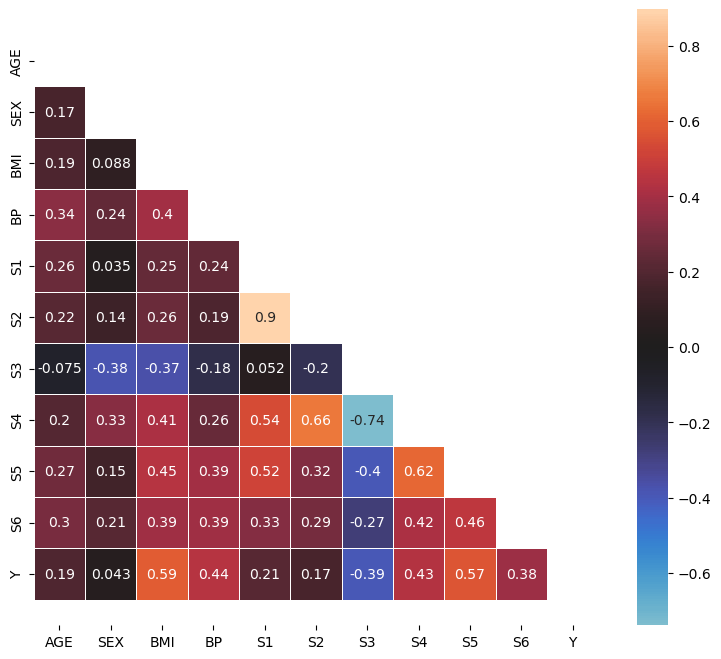

In [13]:
plt_correlation_matrix(df.corr()) # plot the correlation table

## Linear Regression

The next step is to do some simple modelling, to test the feasability of models. Here we will do this with linear regression. To perform regression modellings we now create a matrix of independent variables (features) given by `X`, and the dependent or target variable `Y`.

In [14]:
X = df.drop(['Y'],axis=1) # drop Y from our dataframe
Y = df['Y'] # create a dataframe with just the Y values

Now we split the data into training and testing sets, and model the data using the  `sklearn` Linear Regression model. Recall the method `fit` trains the data, then `predict` uses the independent test variables to predict the target values. This can be compared against the dependent test variables to calculate $R^2$, the square of the correlation coefficient. The method `score` calculates $R^2$ for the training set. This will typically be greater than the $R^2$ for the testing set. As is apparent the fit is not fantastic, but we will see if it can be improved using regularization.

In [15]:
rng = np.random.RandomState(1) # make sure the results are repeatable
# split into a training set with 80% of the data, and a testing set as the remainder
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.8) 
linear = LinearRegression() # instantatiate the linear regression model
linear.fit(X_train,Y_train) # fit the data to the model
training_score = linear.score(X_train,Y_train) # calculate rsq for the training set
# use the independent variables for the testing set to predict the target variable
preds_linear = linear.predict(X_test) 
# calculate the correlation of the predicted and actual target variables
rsquared_linear = r2_score(Y_test,preds_linear) 
# print the training and testing scores
print("Training score is",round(training_score,4))
print("Testing score is",round(rsquared_linear,4))

Training score is 0.617
Testing score is 0.4325


We can also evaluate the model graphically by plotting the predicted test values against the actual test values, and plotting the line of best fit for this data. This is compared against the line $x=y$, which is shown in black, and will alway have a greater slope that the line of best fit. 

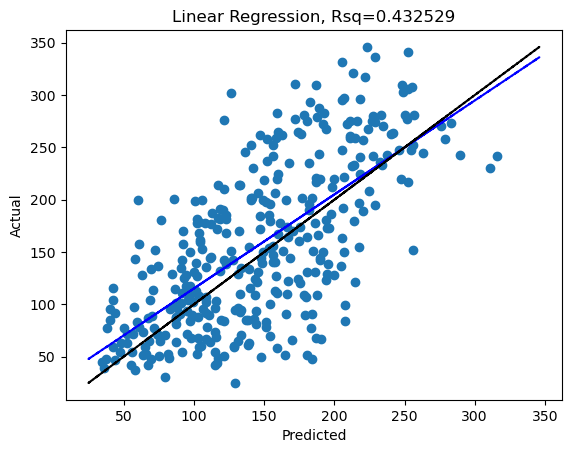

In [16]:
plt.scatter(preds_linear,Y_test) # scatter plot of predicted values against actual values
# use numpy polyfit and poly1d to create a function for the line of best fit, then plot this function in blue
p1 = np.poly1d(np.polyfit(preds_linear, Y_test, 1))
plt.plot(Y_test,p1(Y_test),'b--')
plt.title("Linear Regression, Rsq=%f" % rsquared_linear) # add a title including the correlation coefficient
plt.xlabel("Predicted") # xlabel
plt.ylabel("Actual") # ylabel
plt.plot(Y_test,Y_test,'k--') # add x=y line in black for comparison
plt.show() # display the final plot

## Analysis of Coefficients

We can investigate the model coefficients to get an idea of the importance of each independent variable in predicting `Y`. However, we cannot directly compare coefficients as their dimensions are different. For example, the `AGE` coefficient will be inversely proportional to years, while the `BP` coefficient will be inversely proportional to mm of Hg. Hence to compare the coefficients we need to make them dimensionless and we also need to take into account the variability of each of the dependent variables. The variability of the features can be obtained from the standard deviation, which also has the same dimensions as the original variables.

To compare the importance of the coefficients it is easiest to normalise the independent variables from the start. The dependent variable does not need to be normalised. We normalise all the variables such that their mean is zero and their standard deviation is one, which can be done by subtracting the mean and then dividing by the standard deviation. This is equivalent to multiplying the coefficients by the standard deviation.

Normalising the coefficients is particularly important for regularization methods such as `Ridge` and `Lasso`, so that coefficients are treated uniformly by the penalty schemes.

In [11]:
nX =(X-X.mean())/X.std() # create nX, a normalised version of X
nX.describe() # show the descriptive statistics of nX

,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02
mean,-3.717489e-17,2.225470e-16,-4.609686e-15,-9.625282e-16,-3.174936e-16,8.386956e-16,-1.446806e-16,-1.708035e-16,1.912089e-15,1.941948e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.251738e+00,-9.374744e-01,-1.895781e+00,-2.360375e+00,-2.662394e+00,-2.427874e+00,-2.148448e+00,-1.604285e+00,-2.648040e+00,-2.893112e+00
25%,-7.832846e-01,-9.374744e-01,-7.188104e-01,-7.697777e-01,-7.192046e-01,-6.375263e-01,-7.374604e-01,-8.293610e-01,-6.981574e-01,-6.967595e-01
50%,1.130443e-01,-9.374744e-01,-1.529591e-01,-1.190789e-01,-9.073818e-02,-8.020037e-02,-1.382738e-01,-5.443750e-02,-4.089059e-02,-2.263165e-02
75%,7.995940e-01,1.064282e+00,6.562083e-01,7.485196e-01,5.955183e-01,6.267323e-01,6.155415e-01,7.204860e-01,6.810788e-01,5.862581e-01
max,2.325260e+00,1.064282e+00,3.581660e+00,2.772916e+00,3.232188e+00,4.174548e+00,3.804760e+00,3.889923e+00,2.805543e+00,2.847848e+00


We repeat the linear regression, but now using the normalized variables. Again the square of the correlation coefficient is around 0.45.

In [12]:
# split into a training set with 80% of the data, and a testing set as the remainder
X_train, X_test, Y_train, Y_test = train_test_split(nX,Y,test_size=0.8, random_state=42) 
linear = LinearRegression() # instantatiate the linear regression model
linear.fit(X_train,Y_train) # fit the data to the model
training_score = linear.score(X_train,Y_train) # calculate rsq for the training set
# use the independent variables for the testing set to predict the target variable
preds_linear = linear.predict(X_test) 
# calculate the correlation of the predicted and actual target variables
rsquared_linear = r2_score(Y_test,preds_linear) 
# print the training and testing scores
print("Training score is",round(training_score,4))
print("Testing score is",round(rsquared_linear,4))

Training score is 0.4689
Testing score is 0.4351


Now we can plot the linear regression coefficients. It can now be seen that `AGE`, `SEX`, `S3`, `S4` and `S6` appear to have the weakest effect on the prediction of Diabetes onset. 

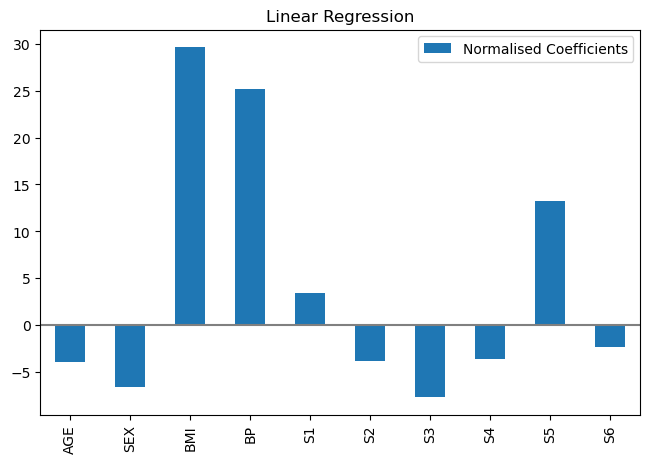

In [13]:
feature_names = X.columns.tolist() # write the column names to a list
# create a new dataframe with the regression coefficients from the normalised data
ncoefs = pd.DataFrame(linear.coef_.transpose(),columns=['Normalised'],index=feature_names) 
# add our original coefficient importance to this dataframe
ncoefs.columns =['Normalised Coefficients'] 
# do a similar horizontal plot as before
ax = ncoefs.plot(kind='bar',figsize=(10,5))
plt.title('Linear Regression')
plt.axhline(y=0, color='.5')
plt.subplots_adjust(left=.3)

However, we need to consider the variability of the coefficients as the training set is varied. This gives an indication of the variance or overfitting of the model.

To investigate the variability we can use the `sklearn` methods `cross_validate` and `RepeatedKFold`. The first of these performs a number of runs of a model. The second splits the data in n sections and repeats the calculations m times. This gives n.m runs to investigate the variability of the coefficients. The variability of these can then be plotted using a box and whisker plot.

We can see `AGE`, `SEX`, `BP`, `BMI` and `S6` have very low variance, whereas `S1`-`S5` have high variance indicative of overfitting. Of the low variance features, `AGE` and `S6` seem to have little effect on the predictions.

Testing score is 0.4839 ± 0.0746


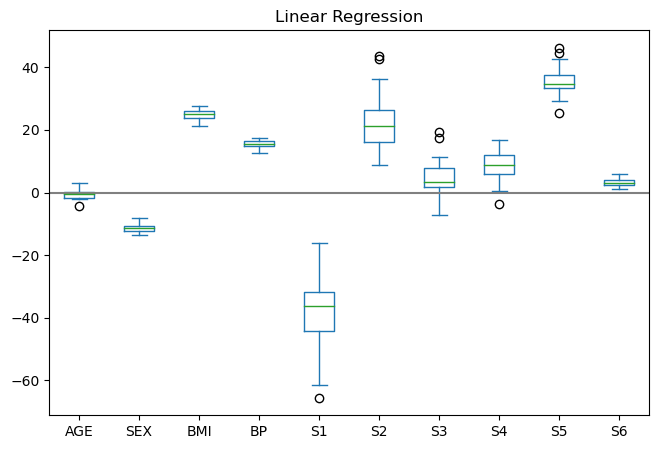

In [14]:
from sklearn.model_selection import cross_validate, RepeatedKFold # import sklearn methods

rng = np.random.RandomState(1) # make sure the results are repeatable
feature_names = nX.columns.tolist() # write the column names to a list
# cross_validate takes the particular model, in this case linear regression which we 
# instantatiated earlier,
# and undertakes a number of runs according the method specified by cv=
# RepeatedKFold splits the data into n sections and repeat the regression modelling 5 times, 
# giving 25 runs
# return_estimator=True returns the fitting data for each run
scores = cross_validate(linear, nX, Y, cv=RepeatedKFold(n_splits=5, n_repeats=5), 
                        return_estimator=True,return_train_score=True)
# take the results for each simulation (estimator), extract the coefficients for each run 
# and add them to a dataframe with columns being the feature names
coefs = pd.DataFrame([est.coef_ for est in scores['estimator']],columns=feature_names)
# plot the descriptive statics of the coefficients in a box and whisker plot to show 
# variability
ax = coefs.plot(kind='box',figsize=(10,5))
plt.title('Linear Regression')
plt.axhline(y=0, color='.5')
plt.subplots_adjust(left=.3)
print('Testing score is',
      round(np.mean(scores['test_score']),4),"±",round(np.std(scores['test_score']),4))


### Regularization 

We now investigate regularization techniques for Linear Regression, to reduce the variance of the model. We will concentrate of ridge regularization, though other possible techniques are lasso and elastic-net regularizations.

To use Ridge regularization (which adds a penalty term which is proportional to the sum of the squares of the coefficients), we need to find the optimal value of the tuning parameter alpha. Here we will first graphically compare the training and testing scores to determine the value of alpha for which we obtain the maximum value of the testing score. To generate the figure we create an array of alpha values, which in this case are logarithmically distributed, and perform a Ridge regularization for each, and store the testing and training scores ( $R^2$ ). Then we plot these against alpha. From the figure we see the optimal value occurs at alpha approximately 20.

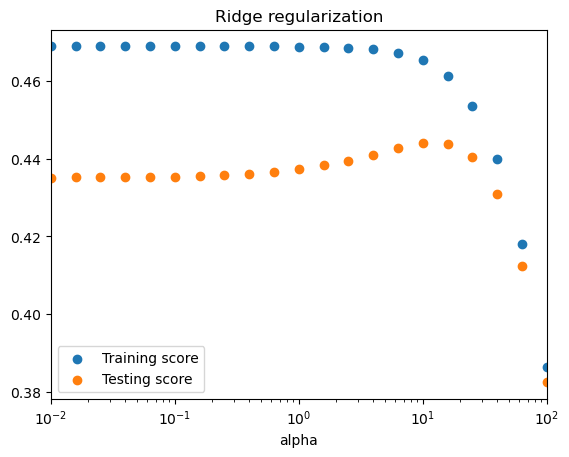

In [15]:
rng = np.random.RandomState(1) # make sure the results are repeatable
# create an array of 21 alpha values logarithmically distributed between 10**(-2) and 10**2
alfas = np.logspace(-2,2,num=21) 
# create two arrays for storage of the same size as alfas, but filled with zeros
ridge_training_score = np.zeros_like(alfas)
ridge_rsquared = np.zeros_like(alfas)
# loop over the values in the alfas array, at each loop the current value is alfa 
# and idx is incremented by 1, starting at 0
for idx, alfa in enumerate(alfas): 
    ridge = Ridge(alpha=alfa) # instantatiate Ridge regularization with the current alfa
    ridge.fit(X_train,Y_train) # train the model to our data set
# calculate the training score and store in the array ridge_training_score
    ridge_training_score[idx] = ridge.score(X_train,Y_train) 
    preds_linear = ridge.predict(X_test) # calculate the model prediction for the test data
# calculate the correlation between the predicted and actual test data and store in the  
# array ridge_rsquared
    ridge_rsquared[idx] = r2_score(Y_test,preds_linear)  
# plot the training score against alpha
plt.scatter(alfas,ridge_training_score,label='Training score') 
# plot the testing score against alpha
plt.scatter(alfas,ridge_rsquared,label='Testing score') 
plt.xscale('log') # make the x-axis a logarithmic scale
plt.gca().set_xlim(left=.01, right=100); # fix the x-axis limits
plt.title('Ridge regularization')
plt.xlabel('alpha');
plt.legend(loc='best');

Now we can investigate Ridge regularization using the optimal value of alpha $\approx$ 20. The variance of the coefficient is significantly reduced and it is apparent that the most important variables are `BMI`, `BP` and `S5`. Note that `S1`-`S4` have varied significantly, due to the collinearity (i.e., the variables are highly correlated).

Testing score is 0.4823 ± 0.0752


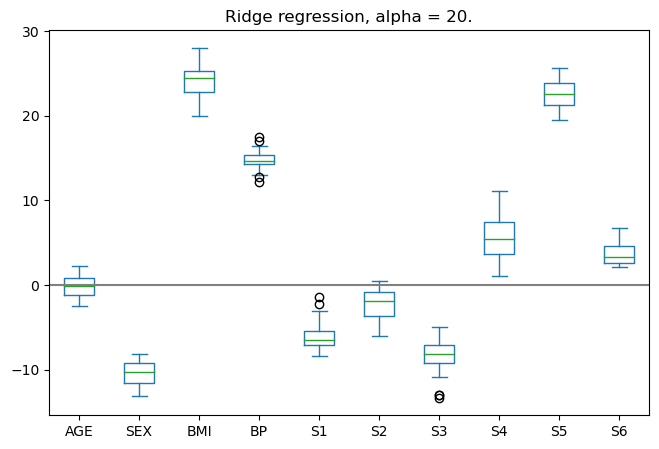

In [16]:
rng = np.random.RandomState(1) # make sure the results are repeatable
feature_names = nX.columns.tolist() # write the column names to a list
# cross_validate takes the particular model, in this case ridge regularization
# and undertakes a number of runs according the method specified by cv=
# RepeatedKFold splits the data into n sections and repeat the regression modelling 5 times, 
# giving 25 runs
# return_estimator=True returns the fitting data for each run
scores = cross_validate(Ridge(alpha=20.), nX, Y, 
                        cv=RepeatedKFold(n_splits=5, n_repeats=5), return_estimator=True)
# take the results for each simulation (estimator), extract the coefficients for each run 
# and add them to a dataframe with columns being the feature names
coefs = pd.DataFrame([est.coef_ for est in scores['estimator']],columns=feature_names)
# plot the descriptive statics of the coefficients in a box and whisker plot to show 
# variability
ax = coefs.plot(kind='box',figsize=(10,5))
plt.title('Ridge regression, alpha = 20.')
plt.axhline(y=0, color='.5')
plt.subplots_adjust(left=.3)
print('Testing score is',
      round(np.mean(scores['test_score']),4),"±",round(np.std(scores['test_score']),4))


### Exercise

Use `RidgeCV` to estimate the optimal value of `alpha` using the array defined above. You should also investigate the
effect of changing the number of cross-validations in the range [4,10]. In this case again use the training and testing sets to fit the model and to test the model. You can use `ridge.score()` to calculate the scores for the test set, and `ridge.alpha_` to find the optimal value of alpha. In general, you should get a similar optimal value of `alpha` to the example above. The use of cross-validations creates a more robust method than the graphical method above. (4 marks)

In [17]:
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Y'])
y = df['Y']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Ridge regression 
alphas = [0.1, 1, 10, 100]


#give range with 4-10
cv_range = range(4, 11)  

for cv in cv_range:
    ridge = RidgeCV(alphas=alphas, cv=cv)
    ridge.fit(X_train, y_train)
    score = ridge.score(X_test, y_test)
    print(f"Cross-Validation: {cv}, Optimal Alpha: {ridge.alpha_}, Test Score: {score}")


Cross-Validation: 4, Optimal Alpha: 1.0, Test Score: 0.4520945451686048
Cross-Validation: 5, Optimal Alpha: 1.0, Test Score: 0.4520945451686048
Cross-Validation: 6, Optimal Alpha: 1.0, Test Score: 0.4520945451686048
Cross-Validation: 7, Optimal Alpha: 1.0, Test Score: 0.4520945451686048
Cross-Validation: 8, Optimal Alpha: 1.0, Test Score: 0.4520945451686048
Cross-Validation: 9, Optimal Alpha: 1.0, Test Score: 0.4520945451686048
Cross-Validation: 10, Optimal Alpha: 10.0, Test Score: 0.4455268080952063


Using code from earlier in the notebook, create a function which takes the normalized feature set (or subset) and target set for the Diabetes data, a particular value of alpha, a number of cross-validations and a number of repititions, and performs and plots an analysis of the coefficients and calculation of the model accuracy using `RidgeCV`. (3 marks)

In [18]:

def analyze_ridge_cv(features, target, alpha, num_cv, num_repeats):
    # Normalize features
    scaler = StandardScaler()
    features_normalized = scaler.fit_transform(features)
    
    
    X_train, X_test, y_train, y_test = train_test_split(features_normalized, target, test_size=0.2, random_state=42)
    
    # Perform Ridge regression with cross-validation
    ridge = RidgeCV(alphas=[alpha], cv=num_cv)
    

    scores = []
    coefficients = []
    for _ in range(num_repeats):
        ridge.fit(X_train, y_train)
        scores.append(ridge.score(X_test, y_test))
        coefficients.append(ridge.coef_)
    
  
    avg_score = np.mean(scores)
    avg_coefficients = np.mean(coefficients, axis=0)
    

    plt.figure(figsize=(10, 6))
    plt.bar(features.columns, avg_coefficients)
    plt.title("Ridge Coefficients")
    plt.xlabel("Features")
    plt.ylabel("Coefficient Value")
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    print(f"Avg. Model Accuracy: {avg_score:.4f}")


Now use the function that you have just created. For the optimal value of `alpha` found using `RidgeCV` in the previous analysis, rerun the analysis of the coefficients and calculation of the model accuracy, but in this case  investigate the effect of individually dropping the columns `AGE`, `S2` and `S4`. (1 marks each)

Drop the `AGE` column.

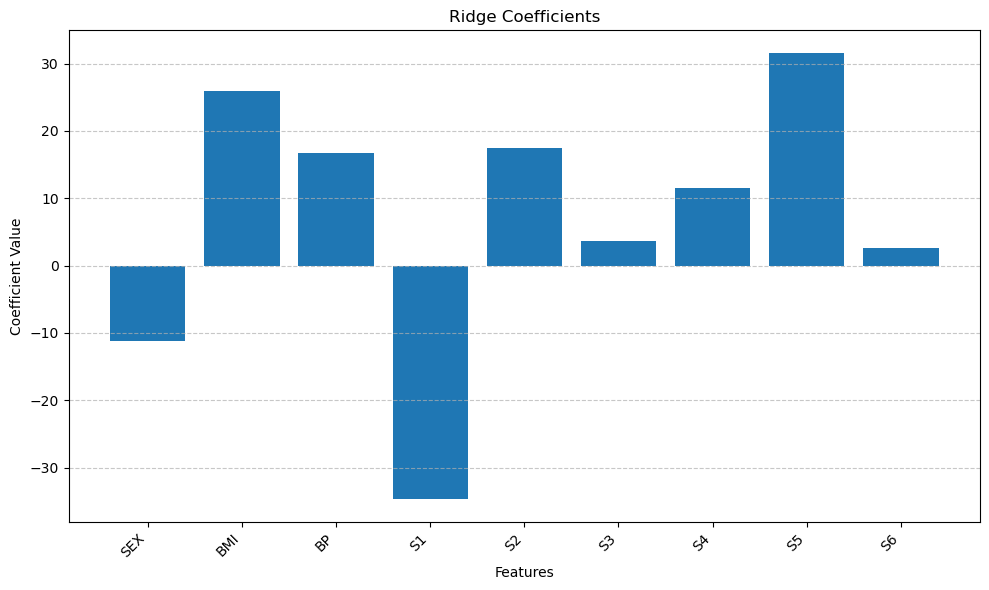

Avg. Model Accuracy: 0.4604


In [19]:

features = df.drop(columns=['AGE', 'Y'])  #removing age column
target = df['Y']
alpha = 1 
num_cv = 5 
num_repeats = 10  

analyze_ridge_cv(features, target, alpha, num_cv, num_repeats)


Drop the `S2` column.

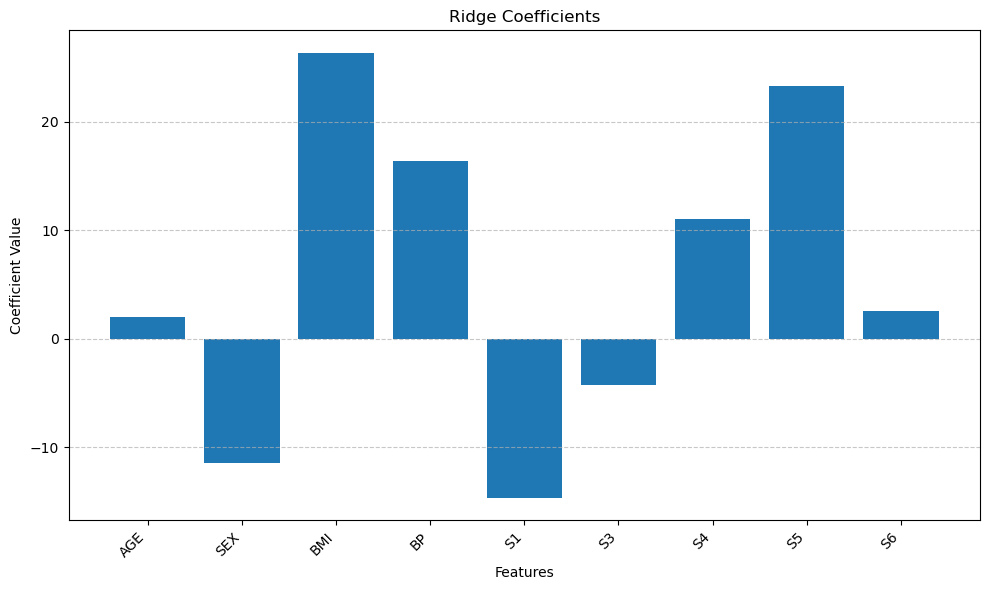

Avg. Model Accuracy: 0.4532


In [20]:

features = df.drop(columns=['S2', 'Y'])  # removing s2 column 
target = df['Y']
alpha = 1  
num_cv = 5  
num_repeats = 10 

analyze_ridge_cv(features, target, alpha, num_cv, num_repeats)


Drop the `S4` column.

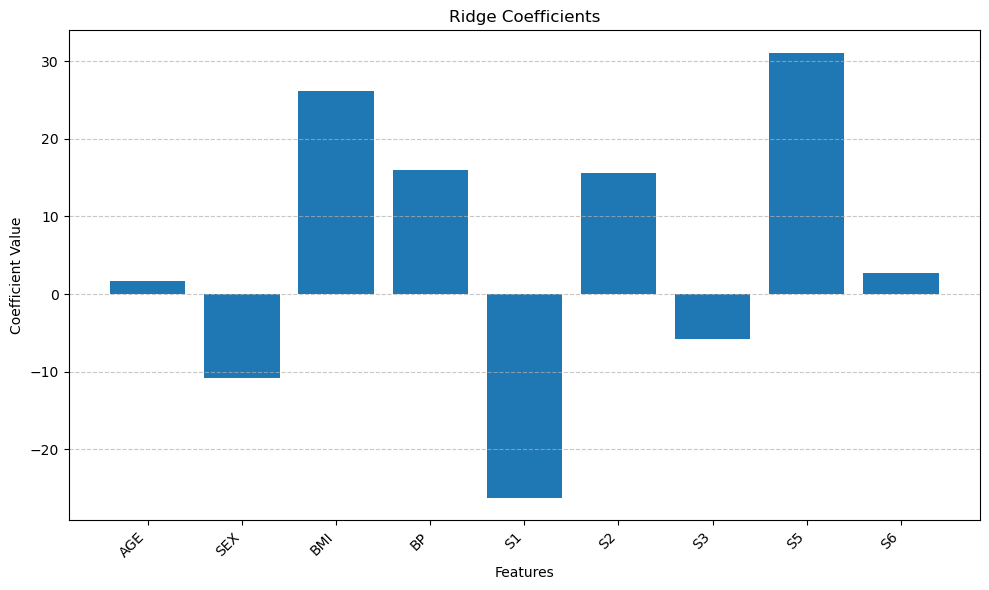

Avg. Model Accuracy: 0.4615


In [21]:

features = df.drop(columns=['S4', 'Y'])  #removing the s4 colum
target = df['Y']
alpha = 1  
num_cv = 5  
num_repeats = 10

analyze_ridge_cv(features, target, alpha, num_cv, num_repeats)
